In [1]:
import numpy as np
import csv
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
COLORS = list(colors.CSS4_COLORS.keys())
import plotly.express as px
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import warnings
import scipy
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import random
import FloRodMethods as frm
from gan_pytorch import *

%matplotlib inline

In [2]:
def load_region(file):  
    df = pd.read_csv(file)
    df.index = df['timestamp']
    del df['timestamp']
    return df

In [3]:
DAYS = [31,28,31,30,31,30,31,31,30,31,30,31]
#useful tool for seeing which day of the year marks the beginning of various months
DAYS_SUM = [sum(DAYS[0:k]) for k in range(12)]
DAYS_SUM

[0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]

In [4]:
df = load_region('county1000.csv')

In [5]:
df

,194565,22533,280581,10250,118794,225290,243737,159770,311322,323609,...,24549,282597,124905,120810,12266,215017,278506,8169,149497,249854
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:15:00,27.90,9.260,4.000,7.610,4.490,20.80,2.271,34.06,4.406,4.520,...,1.214,0.4448,1.1320,12.625,6.137,1.201,24.60,3.834,5.586,2.172
2018-01-01 00:30:00,31.20,9.266,3.973,7.613,4.490,20.81,2.488,32.60,4.402,4.520,...,1.203,0.3374,1.2440,12.550,6.082,1.201,23.97,3.800,5.360,2.172
2018-01-01 00:45:00,27.67,9.280,3.895,7.620,4.490,20.81,2.396,31.64,4.290,4.520,...,1.141,0.3403,0.9910,12.440,6.040,1.201,23.94,3.684,5.273,2.172
2018-01-01 01:00:00,27.66,9.305,3.852,7.630,4.490,20.83,2.162,30.97,4.230,4.520,...,1.606,0.3152,0.9893,12.375,5.543,1.201,23.95,3.710,5.200,2.172
2018-01-01 01:15:00,28.17,28.530,3.871,23.530,4.594,31.47,2.658,26.61,4.020,13.370,...,4.150,2.3520,1.4750,13.400,6.387,5.970,32.56,3.258,5.125,2.428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:00:00,29.17,9.195,4.270,7.550,4.490,21.38,2.164,44.47,4.610,4.523,...,2.035,0.5140,0.7275,16.890,6.240,1.201,24.40,4.070,7.510,2.172
2018-12-31 23:15:00,28.78,9.195,4.130,7.566,4.490,21.27,2.420,41.50,4.492,4.523,...,1.847,0.5273,0.9795,13.090,6.230,1.201,24.00,3.992,6.926,2.172
2018-12-31 23:30:00,28.58,9.220,4.086,7.580,4.490,21.20,2.484,39.70,4.450,4.523,...,1.624,0.5454,0.9480,13.016,6.227,1.201,24.05,3.941,6.598,2.172


In [6]:
clusters = np.load('kmeans112.npy')

In [7]:
data = np.asarray(df[DAYS_SUM[5]*24*4:DAYS_SUM[8]*24*4]).astype('float16').T
#only rows corresponding to june through august, and transposing it in the form of an array

In [8]:
blds, t_len = data.shape

In [9]:
num_days = t_len//(24*4)
num_days

92

In [10]:
data_days = data.reshape(blds,num_days,24*4)
#tensor of blds, by days, by daily measurements

In [11]:
two_days = np.zeros((blds,num_days-1,24*4*2))
for i in range(num_days-1):
    two_days[:,i,:] = np.concatenate([data_days[:,i,:],data_days[:,i+1,:]],axis=1)
#similar as above but now it's two day blocks, s.t. we have day 0 through 1, 1 through 2, etc.

## Choosing a cluster

In [12]:
c = 71

In [13]:
blds_in_c = np.squeeze(np.argwhere((clusters==71).astype(int)))
print('cluster: ',c,' \nhas buildings: ',blds_in_c)
blds_tst =  blds_in_c[[1,4,8]]
print('we choose: ',blds_tst)


cluster:  71  
has buildings:  [ 128  148  282  362  699  801  834 1001 1064]
we choose:  [ 148  699 1064]


Building  128  in cluster  71


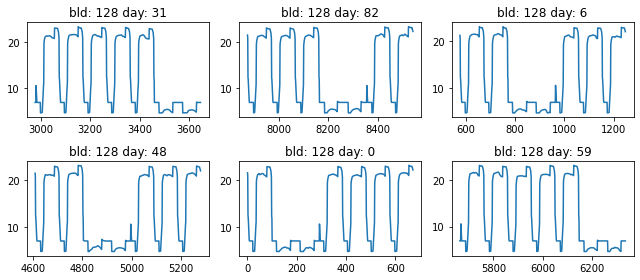



Building  148  in cluster  71


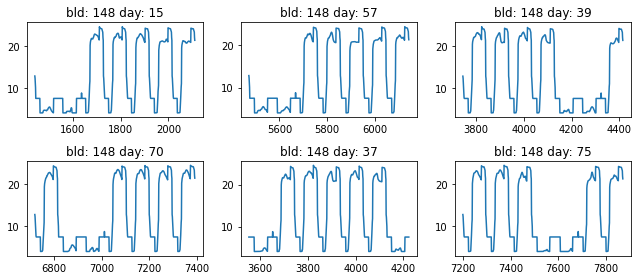



Building  282  in cluster  71


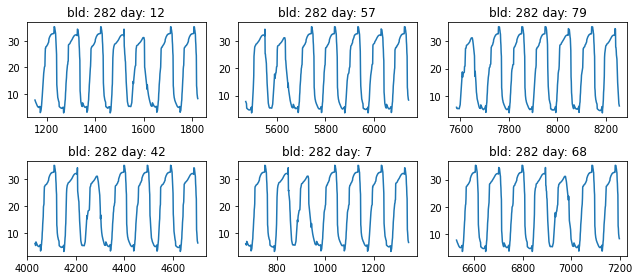



Building  362  in cluster  71


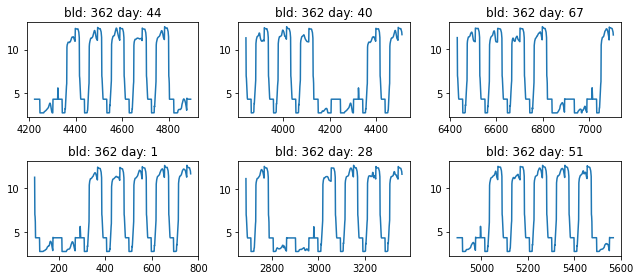



Building  699  in cluster  71


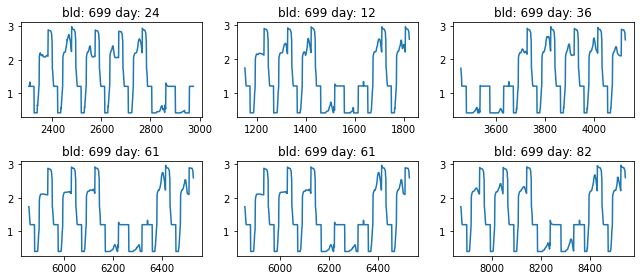



Building  801  in cluster  71


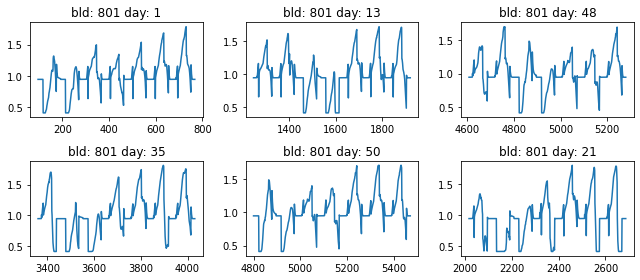



Building  834  in cluster  71


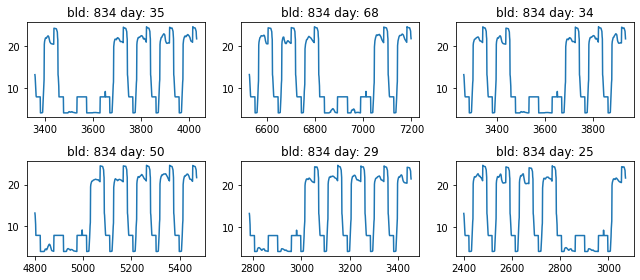



Building  1001  in cluster  71


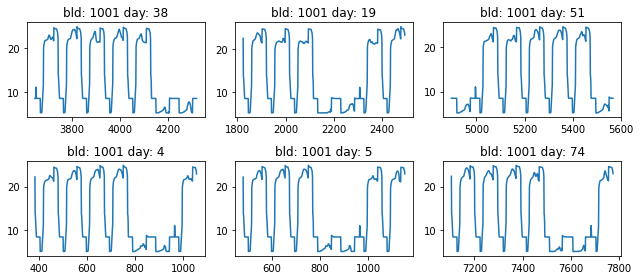



Building  1064  in cluster  71


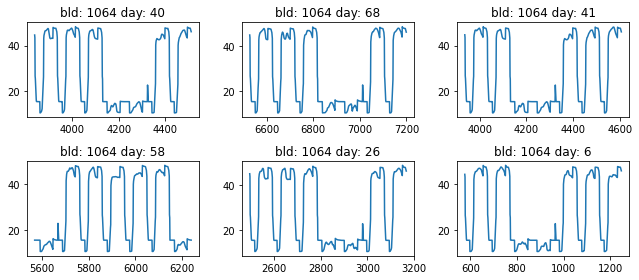

In [14]:
#data analysis
for j in blds_in_c:
    print('Building ',j,' in cluster ',c)
    plt.subplots(2,3, figsize = (9,4))
    bld = j
    for i in range(6):
        plt.subplot(2,3,i+1)
        day = np.random.randint(0,num_days-8)
        plt.plot(np.arange(day*24*4,(day+7)*24*4),data[bld,day*24*4:(day+7)*24*4])
        plt.title('bld: '+str(bld)+ ' day: '+str(day))
    plt.tight_layout()
    plt.show()
    print('\n')

In [15]:
xs = {}
for bld in blds_in_c:
    x,y = frm.splitSeqs(data[bld],11*24*4,24*4)
    xs['x'+str(bld)] = x
    xs['y'+str(bld)] = y

In [16]:
for k in xs:
    print(k,xs[k].shape)

x128 (7681, 1056)
y128 (7681, 96)
x148 (7681, 1056)
y148 (7681, 96)
x282 (7681, 1056)
y282 (7681, 96)
x362 (7681, 1056)
y362 (7681, 96)
x699 (7681, 1056)
y699 (7681, 96)
x801 (7681, 1056)
y801 (7681, 96)
x834 (7681, 1056)
y834 (7681, 96)
x1001 (7681, 1056)
y1001 (7681, 96)
x1064 (7681, 1056)
y1064 (7681, 96)


In [17]:
x,y = xs['x128'],xs['y128']

In [18]:
xn  = (x-np.mean(x,axis=1,keepdims=True))/np.std(x,axis=1, keepdims=True)

In [19]:
xn

array([[ 1.18   ,  1.102  , -0.00931, ...,  1.3    ,  1.269  ,  1.244  ],
       [ 1.102  , -0.00931, -0.08997, ...,  1.269  ,  1.244  ,  1.157  ],
       [-0.00931, -0.08997, -0.2534 , ...,  1.244  ,  1.157  ,  1.076  ],
       ...,
       [-1.021  , -1.021  , -1.021  , ...,  1.113  ,  1.086  ,  1.059  ],
       [-1.024  , -1.024  , -1.024  , ...,  1.084  ,  1.057  ,  1.025  ],
       [-1.026  , -1.026  , -1.026  , ...,  1.055  ,  1.023  ,  0.9966 ]],
      dtype=float16)

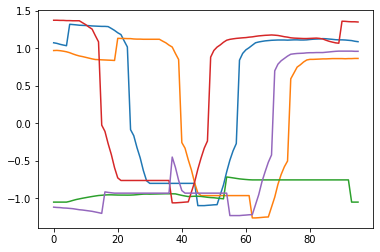

In [20]:
for i in np.random.randint(0,xn.shape[0],5):
    plt.plot(xn[i,:24*4])

In [21]:
D = discriminator().type(dtype)

# Make the generator
G = generator().type(dtype)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)

In [22]:
images = run_a_gan(
    D,
    G,
    D_solver,
    G_solver,
    discriminator_loss,
    generator_loss,
    xn
)

running


In [23]:
rn = np.random.randn(10,88)
import torch

In [24]:
out = G(torch.as_tensor(rn,dtype=torch.float))

In [25]:
outarr =np.asarray(out.detach())

Loop:  0
running


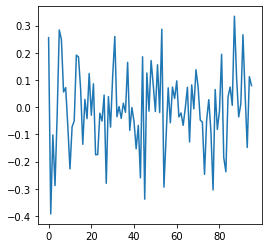

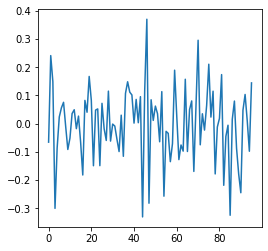

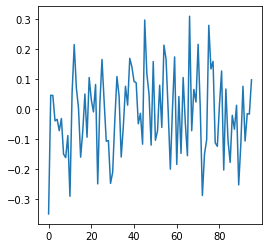

Loop:  1
running


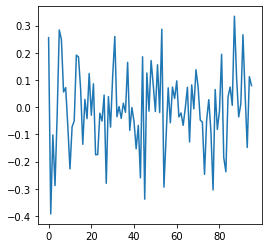

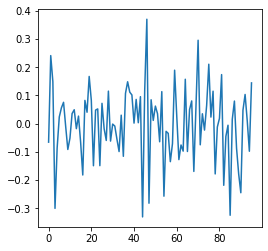

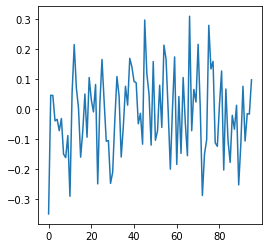

Loop:  2
running


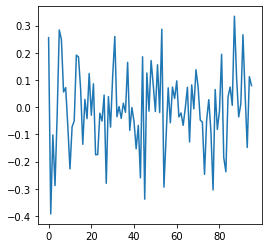

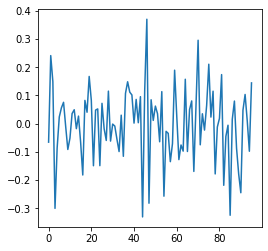

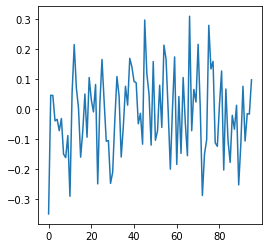

Loop:  3
running


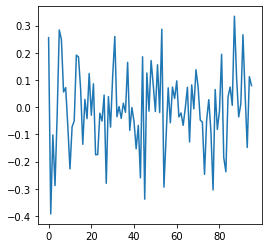

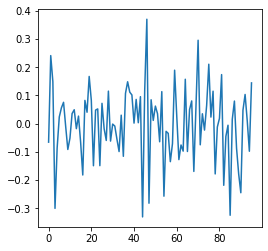

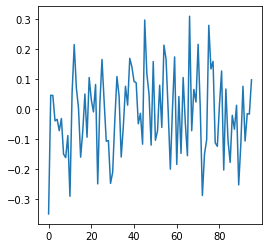

Loop:  4
running


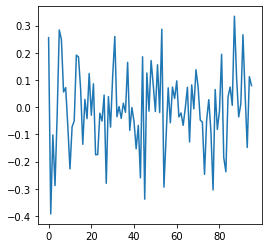

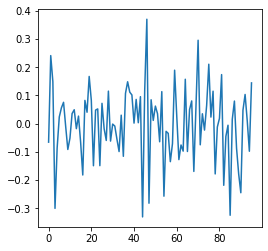

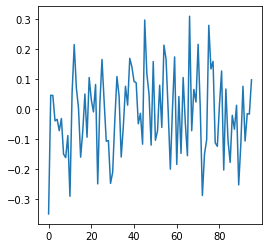

Loop:  5
running


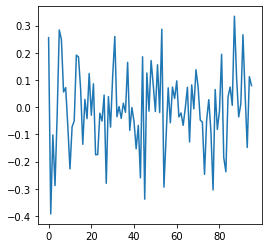

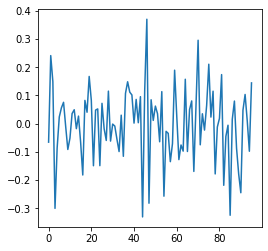

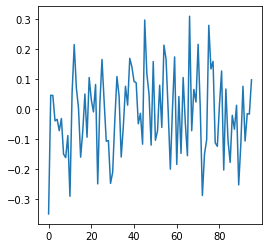

Loop:  6
running


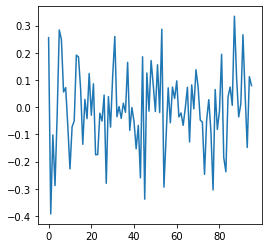

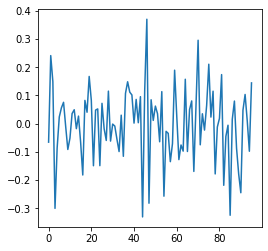

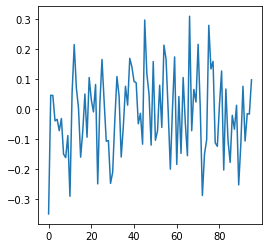

Loop:  7
running


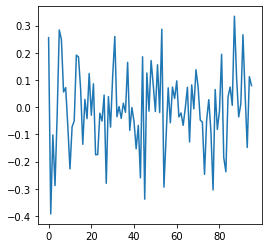

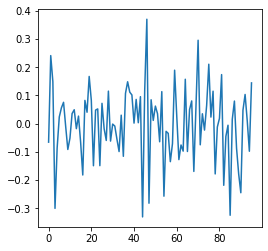

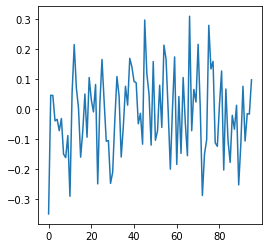

Loop:  8
running


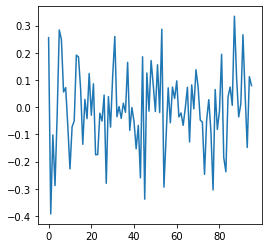

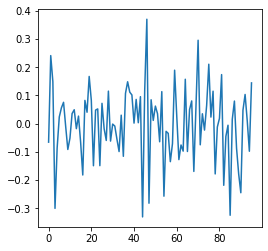

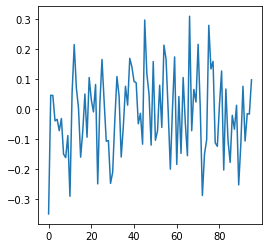

Loop:  9
running


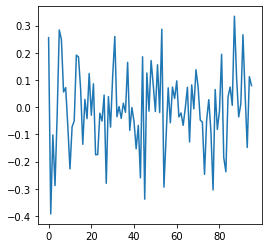

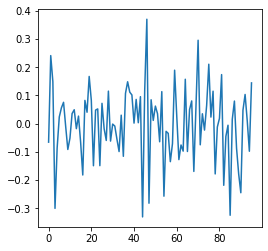

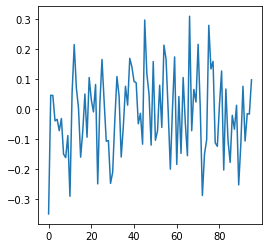

Loop:  10
running


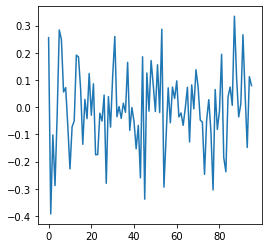

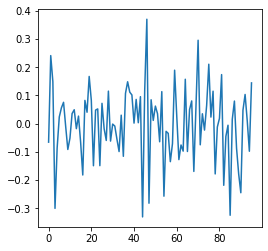

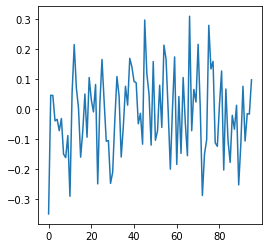

Loop:  11
running


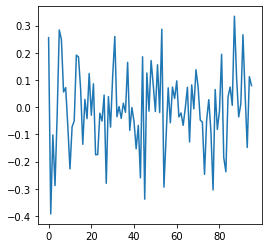

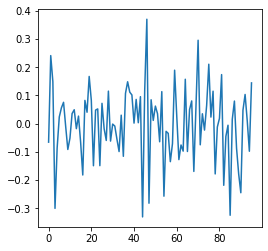

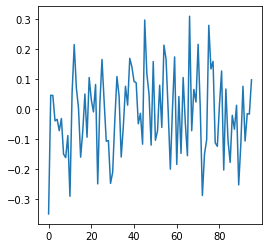

Loop:  12
running


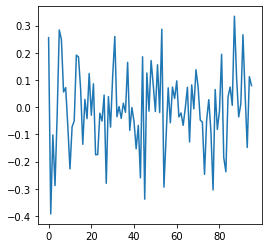

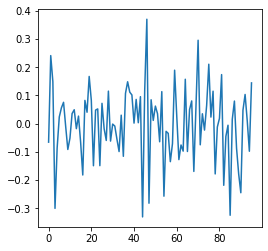

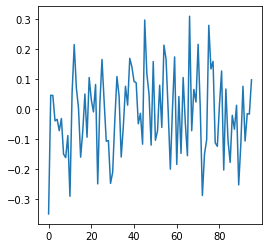

Loop:  13
running


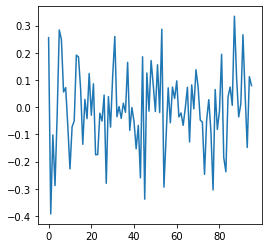

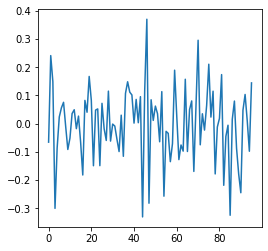

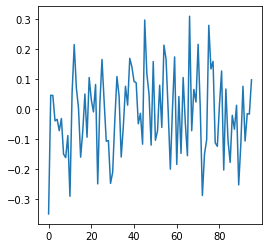

Loop:  14
running


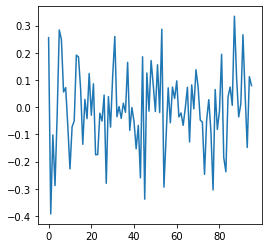

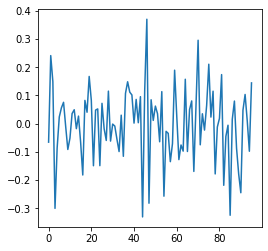

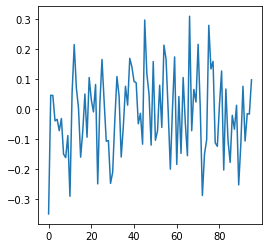

Loop:  15
running


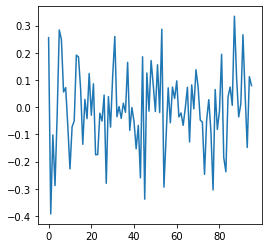

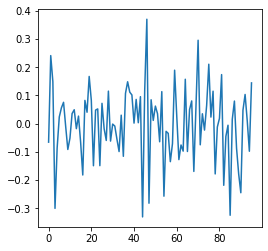

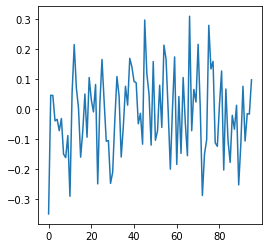

Loop:  16
running


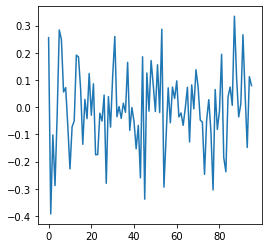

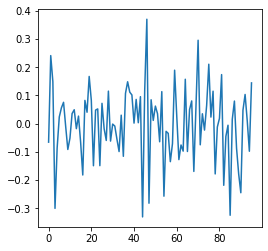

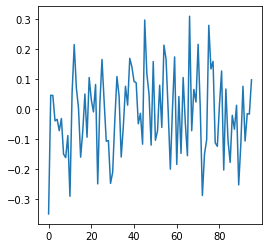

Loop:  17
running


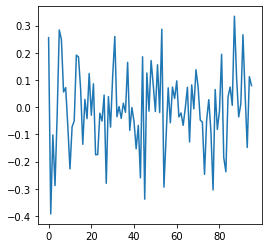

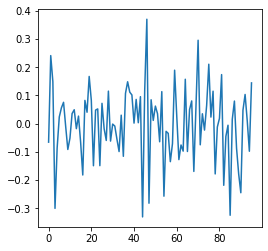

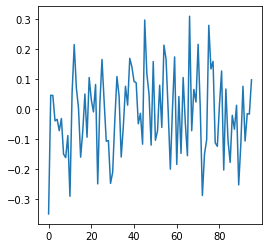

Loop:  18
running


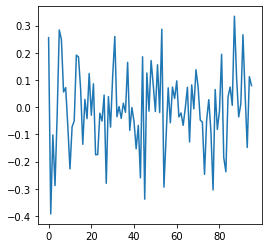

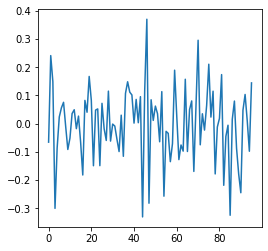

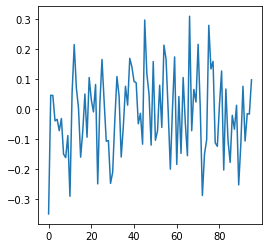

Loop:  19
running


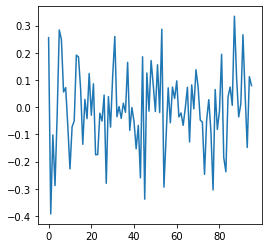

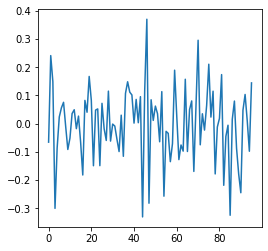

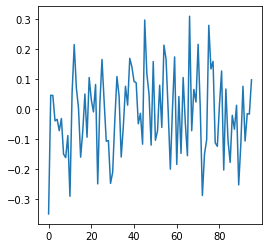

In [26]:
for j in range(20):
    print('Loop: ',j)
    images = run_a_gan(
        D,
        G,
        D_solver,
        G_solver,
        discriminator_loss,
        generator_loss,
        xn,
        num_epochs=100
    )
    out = G(torch.as_tensor(rn,dtype=torch.float))
    outarr =np.asarray(out.detach())

    for i in outarr[:3,:]:
        plt.figure(figsize=(4,4))
        plt.plot(i)
        plt.show()

Loop:  0
running


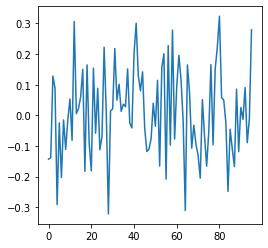

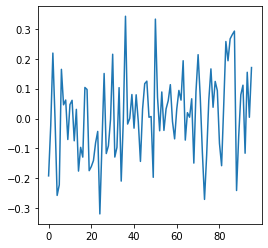

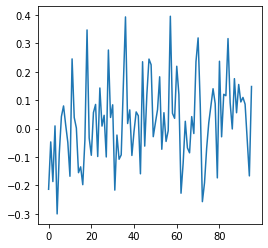

Loop:  1
running


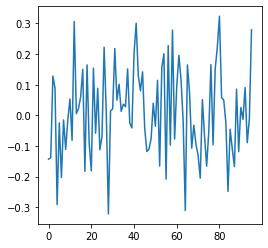

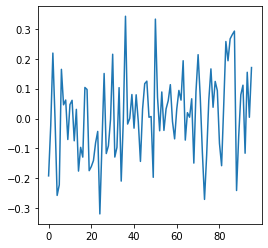

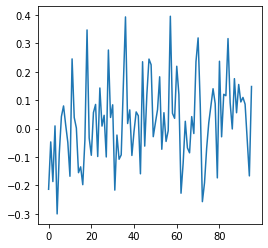

Loop:  2
running


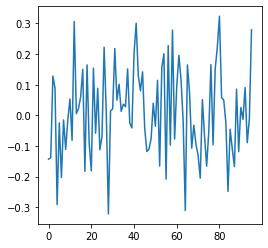

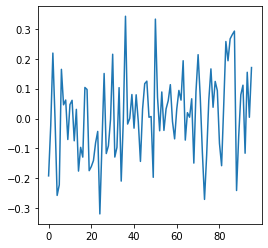

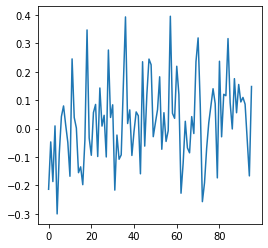

Loop:  3
running


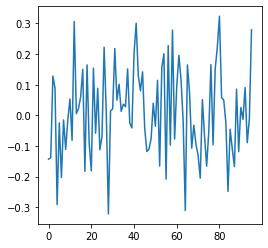

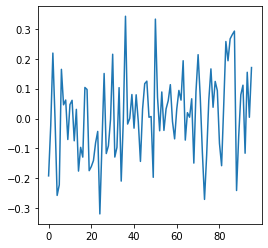

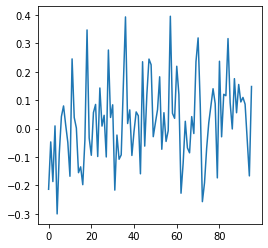

Loop:  4
running


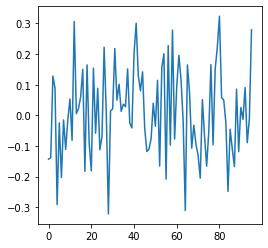

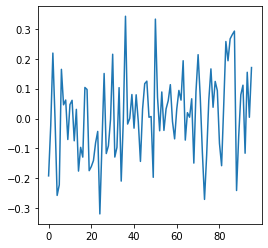

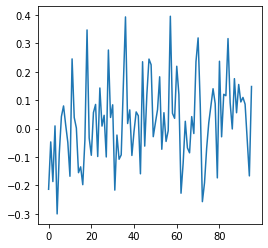

Loop:  5
running


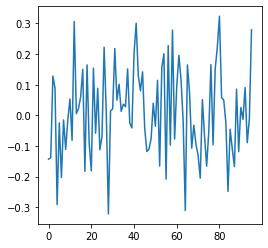

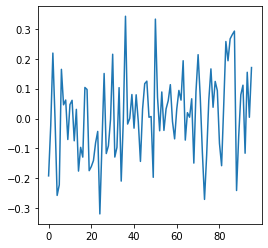

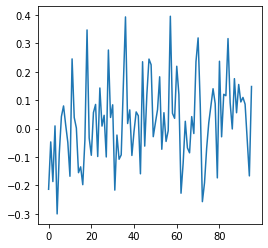

Loop:  6
running


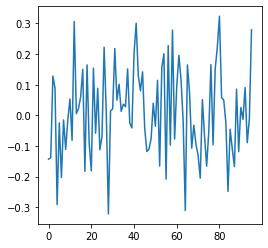

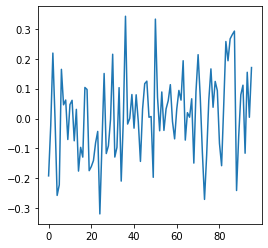

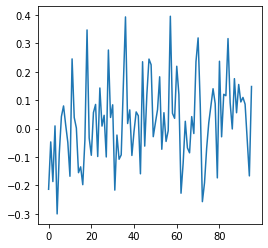

Loop:  7
running


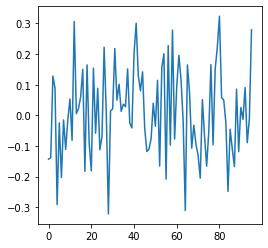

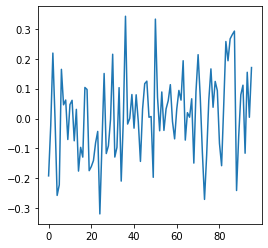

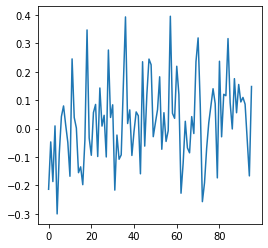

Loop:  8
running


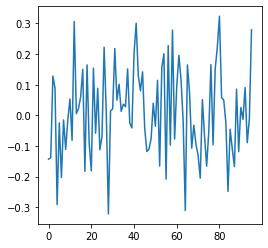

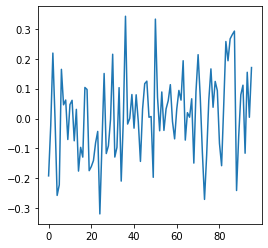

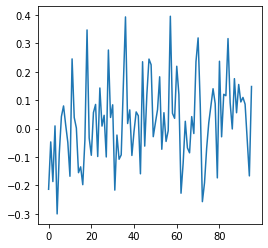

Loop:  9
running


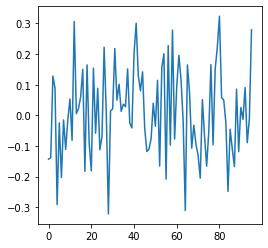

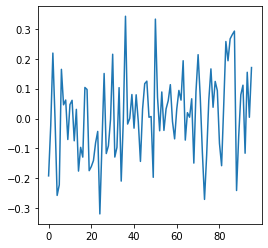

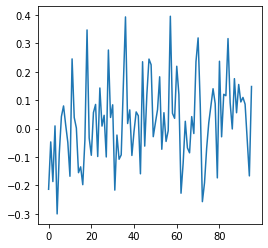

Loop:  10
running


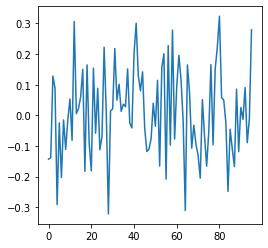

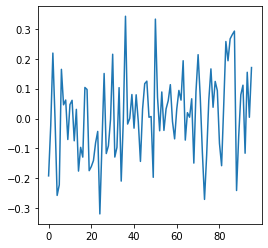

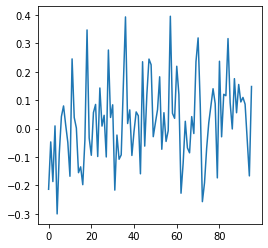

Loop:  11
running


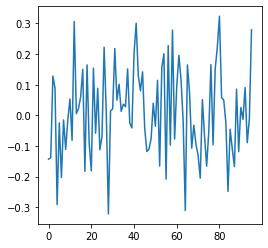

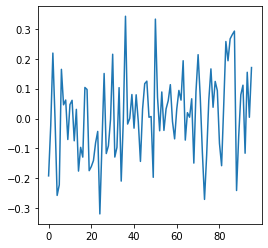

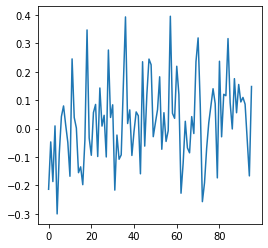

Loop:  12
running


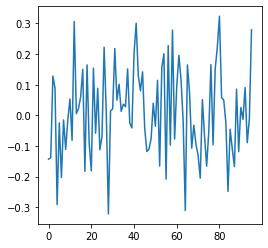

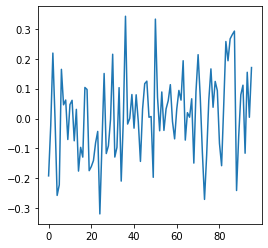

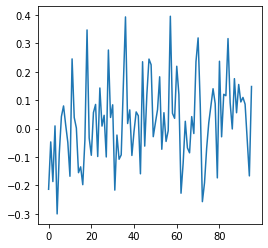

Loop:  13
running


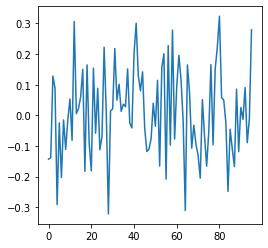

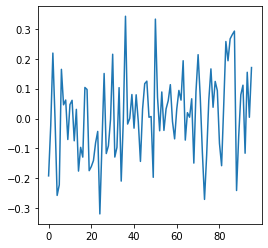

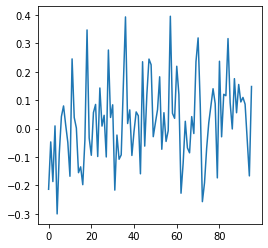

Loop:  14
running


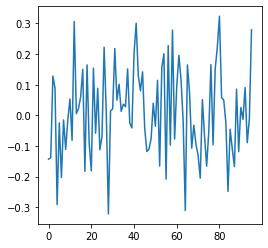

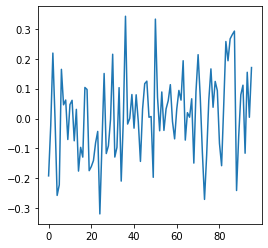

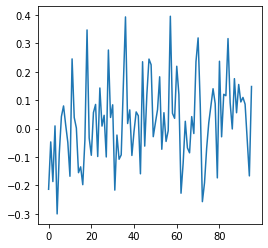

Loop:  15
running


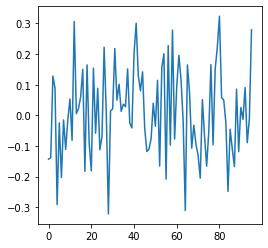

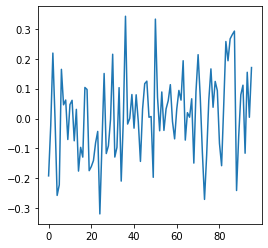

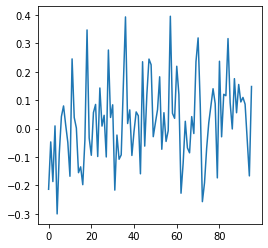

Loop:  16
running


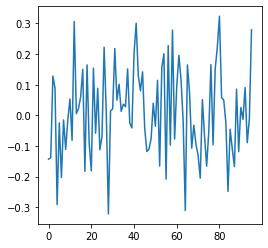

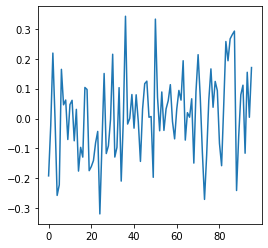

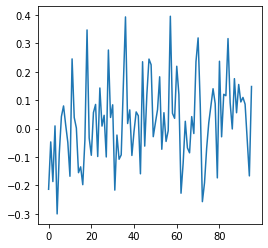

Loop:  17
running


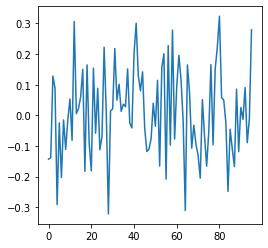

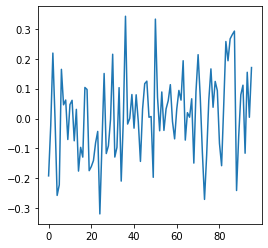

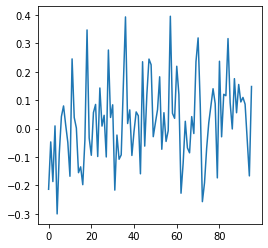

Loop:  18
running


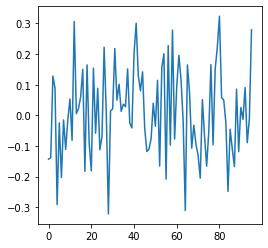

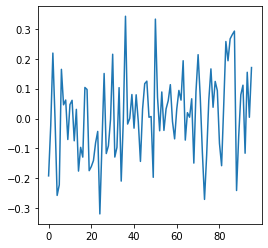

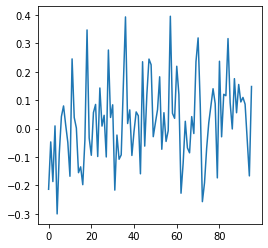

Loop:  19
running


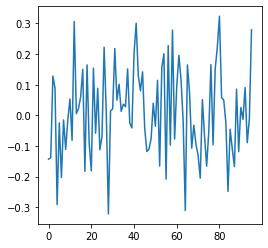

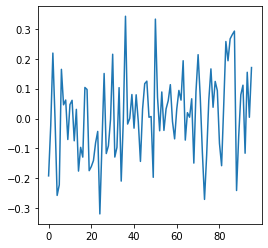

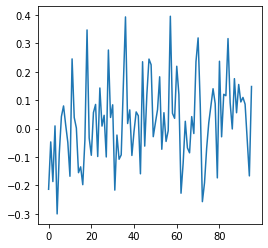

In [27]:
D_LS = discriminator().type(dtype)
G_LS = generator().type(dtype)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

for j in range(20):
    print('Loop: ',j)
    images = run_a_gan(
        D_LS,
        G_LS,
        D_LS_solver,
        G_LS_solver,
        ls_discriminator_loss,
        ls_generator_loss,
        xn,
        num_epochs=100
    )
    out = G_LS(torch.as_tensor(rn,dtype=torch.float))
    outarr =np.asarray(out.detach())

    for i in outarr[:3,:]:
        plt.figure(figsize=(4,4))
        plt.plot(i)
        plt.show()


In [28]:
D_LS?

In [33]:
images = run_a_gan(
    D_LS,
    G_LS,
    D_LS_solver,
    G_LS_solver,
    ls_discriminator_loss,
    ls_generator_loss,
    xn,
    num_epochs=2000,
    show_every=200
)

running


In [34]:
images

[]

In [32]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, loader_train, show_every=250,
              batch_size=128, noise_size=NOISE_DIM, num_epochs=10):
    """
    Train a GAN!

    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    images = []
    print('running')
    iter_count = 0
    for epoch in range(num_epochs):
        for x in loader_train:
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = x.type(dtype)
            
            logits_real = D(2* (real_data - 0.5)).type(dtype)            

            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images.view(batch_size, 1,11*24*4 ))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed)
            gen_logits_fake = D(fake_images.view(batch_size, 1,11*24*4))
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                images.append(imgs_numpy[0:16])

            iter_count += 1

    return images